In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

import pickle
from utils import scatter_plot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor

In [2]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [4]:
X_scaler = StandardScaler()
X_train_ = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train_ = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test_ = X_scaler.transform(X_test).astype('float32')

In [5]:
with open('./data/ml_weights/rf_best_model', "rb") as fp:
    rfr = pickle.load(fp)

with open('./data/ml_weights/xgb_best_model', "rb") as fp:
    xgb = pickle.load(fp)

with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp = pickle.load(fp)

with open('./data/ml_weights/svr_best_model', "rb") as fp:
    svr = pickle.load(fp)

In [46]:
estimators = [('rf', rfr), ('xgb', xgb), ('mlp', mlp), ('svr', svr)]
reg = StackingRegressor(estimators=estimators, cv='prefit', final_estimator=XGBRegressor(learning_rate=0.15, n_estimators=200, random_state=42))

In [47]:
reg.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

StackingRegressor(cv='prefit',
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=14,
                                                     max_features='auto',
                                                     min_samples_split=5,
                                                     n_estimators=10, n_jobs=-1,
                                                     random_state=42)),
                              ('xgb',
                               GradientBoostingRegressor(learning_rate=0.14264219278216356,
                                                         n_estimators=400,
                                                         random_state=42)),
                              ('mlp',
                               MLPRegressor(hidden_layer_sizes=(50, 50, 50),
                                            max_iter=100)),
                              ('svr', SVR(C=10, gamma=0.1))],
                  final_estimator=GradientBoostingRegressor(learning_rate=0.15,
                                                            n_estimators=200,
                                                            random_state=42))

In [48]:
ens_pred = reg.predict(X_test.to_numpy())

NSE: 0.9808, R2: 0.9812, PBias: -0.0082, MSE: 0.8549


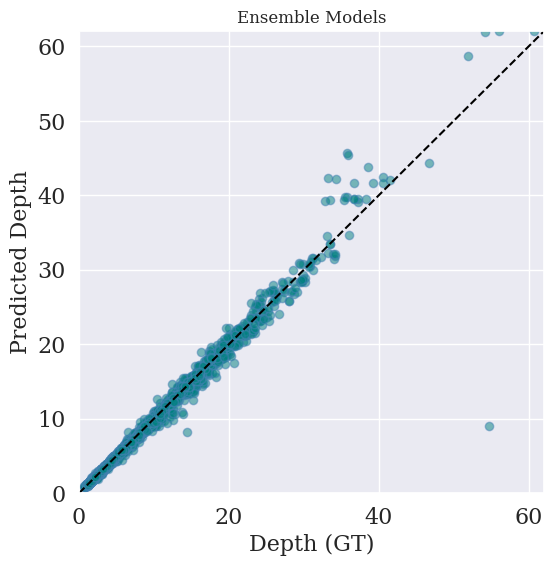

In [49]:
scatter_plot(y_test, ens_pred, model_name='Ensemble Models')

In [50]:
with open('./data/ml_weights/ensemble_model', "wb") as fp:
    pickle.dump(reg, fp)

In [39]:
rfr_pred = rfr.predict(X_test.to_numpy())
xgb_pred = xgb.predict(X_test.to_numpy())
mlp_pred = mlp.predict(X_test_); mlp_pred = y_scaler.inverse_transform(mlp_pred.reshape(-1, 1)).ravel()
svr_pred = svr.predict(X_test_); svr_pred = y_scaler.inverse_transform(svr_pred.reshape(-1, 1)).ravel()

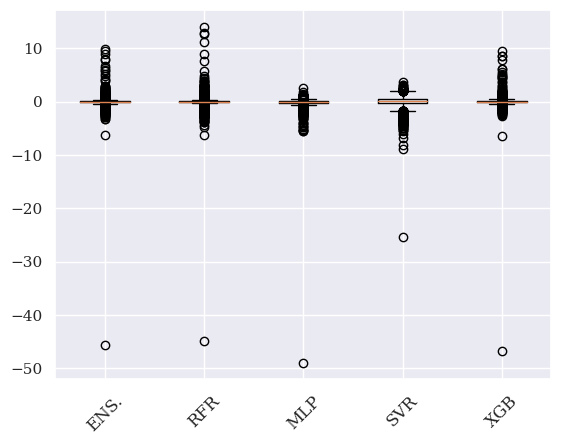

In [51]:
data = [ens_pred - y_test.to_numpy().ravel(),
        rfr_pred - y_test.to_numpy().ravel(),
        mlp_pred - y_test.to_numpy().ravel(),
        svr_pred - y_test.to_numpy().ravel(),
        xgb_pred - y_test.to_numpy().ravel(),
        ]

fig, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels(['ENS.', 'RFR', 'MLP', 'SVR', 'XGB'])
ax.tick_params(axis='x', labelrotation=45, labelsize=12)

ax.grid(True)
plt.show()